[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/guiwitz/DLImaging/blob/master/notebooks/02-Simple_inference_vgg16.ipynb)

# 2. Very accessible deep learning

One can use Deep Learning at different levels:
1. Define a network, train it and use it
2. Use the structure of a network, train and use it
3. Use a pre-trained network, refine its training and use it
4. Finally, simply use a pre-trained network as a black box

Before exploring the more advanced approaches 1-3 we first show here how easy it has become to use powerful deep learning solutions for images in a few lines of code. This example will be our first window into DL. After just using it, we will "decompose" it and explore the different bricks it is made of in the next chapters.

In [1]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

## Loading a pre-trained network from PyTorch

Several packages have developed along PyTroch in order to deal with different specific needs of DL. Torchvision which deals with image-related topics is one of these libraries. It provides popular pre-trained networks, standard datasets as well as functions specifically designed for images that one can integrate into a network.

We start here by importing the VGG16 network (details later) with pre-trained weights:

In [2]:
import torchvision.models as models
import torch
import numpy as np

In [3]:
vgg16 = models.vgg16(pretrained=True)

Now we import an image that we want to classify:

In [4]:
import skimage
import matplotlib.pyplot as plt

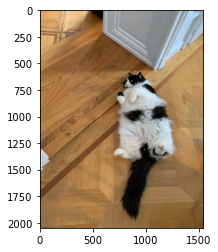

In [5]:
#image = skimage.io.imread(datapath.joinpath('data/woody_face.JPG'))
#image = skimage.io.imread(datapath.joinpath('data/woody_bulle.JPG'))
image = skimage.io.imread(datapath.joinpath('data/woody_allonge.jpg'))
#image = skimage.io.imread('https://upload.wikimedia.org/wikipedia/commons/e/e9/Goldfish3.jpg')
plt.imshow(image);

We only have to do some pre-processing of the image, so that it fits in the network and calculation is fast. We will come back to this step later.

In [8]:
def preproc(image):
    image = skimage.transform.rescale(image,0.2, channel_axis=2)
    image_normalized = (image-np.array([0.485, 0.456, 0.406]))/np.array([[0.229, 0.224, 0.225]])
    image_tensor = torch.tensor(image_normalized, dtype=torch.float32)
    image_tensor = image_tensor.permute(2,0,1)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

In [9]:
image_tensor = preproc(image)

Now we set the network to *evaluation* state and pass our image through it:

In [10]:
vgg16.eval()
result = vgg16(image_tensor)
result.shape

torch.Size([1, 1000])

As expected, the result is a 1000 elements long vector where each element represents the probability of the corresponding class. Here we only have a list of indices, but we would like to match it to the list of 1000 features of the Imagenet dataset. So we download that list and make a dictionary:

In [11]:
import requests
url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
data = requests.get(url).json()
label_dict = {x: data[x] for x in range(len(data))}

Now we can sort the indices and take the 10 largest ones

In [12]:
values, indices = torch.sort(result, descending=True)
indices_numpy = indices.numpy()

In [13]:
for i in range(10):
    print(label_dict[indices_numpy[0,i]])

collie
Border Collie
doormat
skunk
Old English Sheepdog
Persian cat
Shetland Sheepdog
Cardigan Welsh Corgi
tabby cat
Alaskan Malamute


The ImageNet dataset is very large and contains many categories. We see that depending on the picture, the network can easily be fooled into thinking that we deal with a dog or even a doormat! However it consistently identifies the presence of an animal in the picture, so we could imagine that re-trained on a narrower set of categories, the network would be very efficient. In fact we will see later that we can even re-use the pre-trained network and fine-tune it for narrower questions. Still it is remarkable that in few lines of code we can exploit such complex software!